# Chpater5 : RNN

In [1]:
import numpy as np
class RNN:
    def __init__(self, Wx, Wh, b):
        self.param = [Wx, Wh, b]
        self.grad = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.param
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.param  
        x, h_prev = h_next = self.cache

        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)

        self.grad[0][...] = dWx
        self.grad[1][...] = dWh
        self.grad[2][...] = db

        return dx, dh_prev

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.param = [Wx, Wh, b]
        self.grads = [np.zeros_like(param) for param in self.param]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

    def forward(self, xs):
        Wx, Wh, b = self.param

        ''' 
        N = mini batch size
        T = data size (T개 분량의 시계열 데이터)
        D = data dimension
        '''
        N, T, D = xs.shape  
        '''
        D : weight dimension (data dimension)
        H : hidden weight size
        '''
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.param)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.param
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]

        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grad):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad

        self.dh = dh

        return dxs

In [5]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(D)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [TimeEmbedding(embed_W), TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
                       TimeAffine(affine_W, affine_b)]
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

## RNNLM 학습 코드

In [8]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print(f"말뭉치 크기 : {corpus_size},   어휘 수 : {vocab_size}")

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    ppl = np.exp(total_loss / loss_count)
    print(f"| 에폭 {epoch + 1} , perplexity {ppl}")
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기 : 1000,   어휘 수 : 418
| 에폭 1 , perplexity 377.1838508779789
| 에폭 2 , perplexity 248.41963778498362
| 에폭 3 , perplexity 219.53896145469284
| 에폭 4 , perplexity 212.53428430255119
| 에폭 5 , perplexity 204.92333790935206
| 에폭 6 , perplexity 202.41113515864515
| 에폭 7 , perplexity 199.0010460175723
| 에폭 8 , perplexity 194.98270825856773
| 에폭 9 , perplexity 190.20321188527535
| 에폭 10 , perplexity 191.00752608845306
| 에폭 11 , perplexity 186.66181380505128
| 에폭 12 , perplexity 190.04259475959267
| 에폭 13 , perplexity 188.39338783534814
| 에폭 14 , perplexity 188.4868463734708
| 에폭 15 , perplexity 189.21305962035618
| 에폭 16 , perplexity 183.5586280617786
| 에폭 17 , perplexity 182.61985194459777
| 에폭 18 , perplexity 179.29996818135544
| 에폭 19 , perplexity 180.33852287217786
| 에폭 20 , perplexity 180.10099507513937
| 에폭 21 , perplexity 178.9754762287921
| 에폭 22 , perplexity 175.3916463026618
| 에폭 23 , perplexity 172.36369338749287
| 에폭 24 , perplexity 172.38193036629704
| 에폭 25 , perplexity 171.05

Text(0.5, 1.0, 'Training Perplexity')

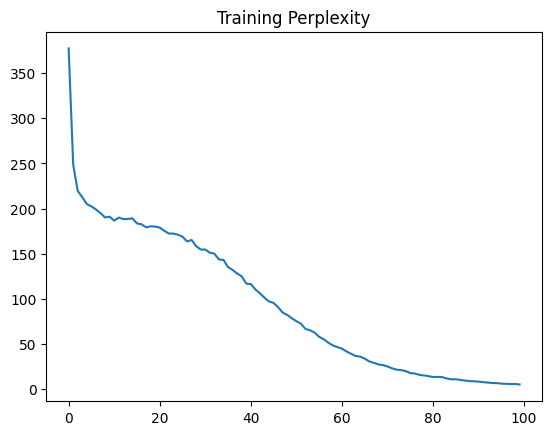

In [11]:
plt.plot(ppl_list)
plt.title("Training Perplexity")

In [12]:
from common.trainer import RnnlmTrainer

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 416.49
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 404.11
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 308.08
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 232.53
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 216.00
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 213.77
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 203.08
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 202.91
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 196.58
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.91
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 193.01
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.07
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.94
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.58
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.46
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.74
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.77
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 184.47
| 에폭 19 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 180.23
| 에폭 20 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 180.67
| 에폭 21 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 177.52
| 에폭 22 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 176.